### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

Данные взяты с:

https://www.kaggle.com/vikasukani/diabetes-data-set

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('diabetes-dataset.csv')

In [3]:
data['Outcome'].value_counts()

0    1316
1     684
Name: Outcome, dtype: int64

In [4]:
X = data.copy()

In [5]:
y = X['Outcome']

In [6]:
X.drop(columns='Outcome', inplace=True)

In [7]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0))
    return f1, roc, rec, prc

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
model = xgb.XGBClassifier()

model.fit(X_train, y_train)
y_predict = model.predict(X_test)

[20:46:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [10]:
results = pd.DataFrame(columns=['model', 'f1', 'roc_auc', 'recall', 'precision'])

In [11]:
f1, roc, rec, prc = evaluate_results(y_test, y_predict)
results = results.append({'model': 'XGBClassifier',
                'f1': f1,
                'roc_auc': roc,
                'recall': rec,
                'precision': prc}, ignore_index=True)

Classification results:
f1: 94.91%
roc: 96.52%
recall: 97.16%
precision: 92.76%


In [12]:
def random_negative_sampling(data, positive_fraction=0.25):
    mod_data = data.copy()
    pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
    np.random.shuffle(pos_ind)
    # leave just 25% of the positives marked
    pos_sample_len = int(np.ceil(positive_fraction * len(pos_ind)))
    pos_sample = pos_ind[:pos_sample_len]
    
    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1
    
    x_data = mod_data.iloc[:,:-2].values
    y_labeled = mod_data.iloc[:,-1].values
    y_positive = mod_data.iloc[:,-2].values
    
    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']==1]
    print(neg_sample.shape, pos_sample.shape)
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

    model = xgb.XGBClassifier()

    model.fit(sample_train.iloc[:,:-2].values, 
              sample_train.iloc[:,-2].values)
    y_predict = model.predict(sample_test.iloc[:,:-2].values)
    return evaluate_results(sample_test.iloc[:,-2].values, y_predict)

In [13]:
fractions = np.arange(0.1, 1, 0.05)

for fraction in fractions:
    f1, roc, rec, prc = random_negative_sampling(data, positive_fraction=fraction)
    results = results.append({'model': 'XGBClassifier pos_fraction='+str(fraction)[:4],
                'f1': f1,
                'roc_auc': roc,
                'recall': rec,
                'precision': prc}, ignore_index=True)

(69, 10) (69, 10)
[20:46:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification results:
f1: 64.56%
roc: 74.48%
recall: 88.61%
precision: 50.78%
(103, 10) (103, 10)
[20:46:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification results:
f1: 63.82%
roc: 74.58%
recall: 85.79%
precision: 50.81%
(137, 10) (137, 10)
[20:46:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification results:
f1

In [14]:
results

,model,f1,roc_auc,recall,precision
0,XGBClassifier,0.949074,0.965216,0.971564,0.927602
1,XGBClassifier pos_fraction=0.1,0.645601,0.744833,0.886054,0.507797
2,XGBClassifier pos_fraction=0.15,0.638211,0.745829,0.857923,0.508091
3,XGBClassifier pos_fraction=0.20,0.652471,0.770428,0.854582,0.527675
4,XGBClassifier pos_fraction=0.25,0.660828,0.792504,0.904139,0.520703
5,XGBClassifier pos_fraction=0.30,0.681818,0.815120,0.890736,0.552283
6,XGBClassifier pos_fraction=0.35,0.702128,0.839340,0.926020,0.565421
7,XGBClassifier pos_fraction=0.40,0.696903,0.842495,0.902579,0.567568
8,XGBClassifier pos_fraction=0.45,0.689735,0.863354,0.967638,0.535842
9,XGBClassifier pos_fraction=0.50,0.701513,0.870136,0.930657,0.562914


In [15]:
import matplotlib.pyplot as plt

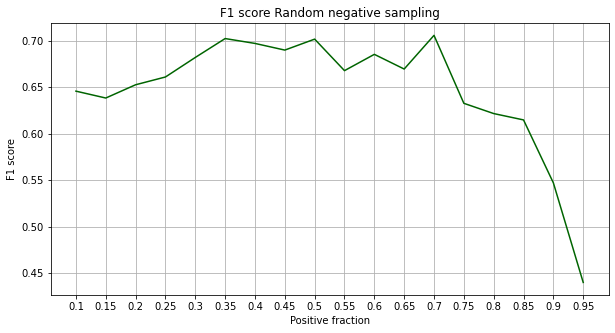

In [16]:
plt.figure(figsize=(10, 5))

plt.grid(axis='both')
plt.title('F1 score Random negative sampling')
plt.xticks(ticks=np.arange(18), labels=np.round(fractions,2))
plt.xlabel('Positive fraction')
plt.ylabel('F1 score')

plt.plot(list(results['f1'][1:]), c='darkgreen');


Даже имея 10% от наших позитивных случаев, мы получаем неплохой f1 score. На графике видно, что наилучших результатов мы достигаем около 35-50%, далее происходит резкое ухудшение модели.